In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis, skew
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [ ]:
# ---------------------
# 1) System Parameters
# ---------------------
SNR_dB = np.arange(-25, 6, 1)  # SNR range in dB
SNR_linear = 10 ** (SNR_dB / 10)

# Channel gains
h_u1_2 = 0.65
h_u2_2 = 2.7
h_oma_2 = 0.6

# Power allocation
alpha1 = 0.8
alpha2 = 0.2

# Detection parameters
Ns = 50
sigma_n2 = 1.0
Pf_u1 = Pf_u2 = Pf_oma = 0.10

# Monte Carlo parameters
num_samples = 10000

# Machine learning parameters
test_size = 0.2

# Cyclic lags for CAF
cyclic_lags = [18, 15]


In [10]:
# ---------------------
# 2) Cyclic Correlation Detection
# ---------------------
def compute_cyclic_threshold(Pf, Ns, sigma_n2):
    return np.sqrt(2 * sigma_n2 / Ns) * norm.ppf(1 - Pf)

def cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2):
    signal_power = alpha * h_2 * SNR
    var_cyclic_H1 = (sigma_n2 + signal_power)**2 / Ns
    return 1 - norm.cdf((lambda_val - signal_power) / np.sqrt(var_cyclic_H1))


In [ ]:
# ---------------------
# 3) ML Data Generation and Feature Extraction
# ---------------------
def extract_features(received_signal):
    mag = np.abs(received_signal)
    
    # CAF features
    caf_values = []
    for lag in cyclic_lags:
        if lag < Ns:
            caf = np.mean(received_signal[:-lag] * np.conj(received_signal[lag:]))
            caf_values.append(np.abs(caf))
    caf_peak = max(caf_values) if caf_values else 0.0
    caf_variance = np.var(caf_values) if len(caf_values) > 1 else 0.0
    
    # Signal power estimate
    signal_power = max(np.mean(mag ** 2) - sigma_n2, 0)
    
    # Statistical features
    mag_kurtosis = kurtosis(mag)
    mag_skewness = skew(mag)

    return [
        np.mean(mag),
        np.std(mag),
        np.sum(mag ** 2),
        np.percentile(mag, 25),
        np.percentile(mag, 75),
        caf_peak,
        caf_variance,
        signal_power,
        mag_kurtosis,
        mag_skewness
    ]

def generate_ml_data(snr_lin, num_samples):
    X, y = [], []
    for _ in range(num_samples):
        signal_present = np.random.rand() > 0.5
        if signal_present:
            x_u1 = np.sqrt(alpha1 * h_u1_2 * snr_lin) * np.random.randn(Ns)
            x_u2 = np.sqrt(alpha2 * h_u2_2 * snr_lin) * np.random.randn(Ns)
            signal = x_u1 + x_u2
        else:
            signal = np.zeros(Ns)
        noise = np.sqrt(sigma_n2 / 2) * (np.random.randn(Ns) + 1j * np.random.randn(Ns))
        received = signal + noise
        features = extract_features(received)
        X.append(features)
        y.append(signal_present)
    return np.array(X), np.array(y)

def train_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'SVM': SVC(probability =True, random_state=42)
    }
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        results[name] = (fpr, tpr, roc_auc)
    return results


In [12]:
# ---------------------
# 4) Throughput Calculation Functions
# ---------------------
def calc_noma_rate_user(alpha, h_2, snr, interference_alpha, interference_h_2):
    numerator = alpha * h_2 * snr
    denominator = interference_alpha * interference_h_2 * snr + sigma_n2
    return np.log2(1 + numerator / denominator)

def calc_oma_rate(h_oma_2, snr):
    return 0.5 * np.log2(1 + (h_oma_2 * snr) / sigma_n2)


In [ ]:
# ---------------------
# 5) Main Simulation
# ---------------------
Pd_u1, Pd_u2, Pd_oma = [], [], []
Pd_rf, Pd_lr, Pd_dt, Pd_svm = [], [], [], []
th_noma_u1, th_noma_u2, th_noma_total = [], [], []
th_oma, th_noma_rf, th_noma_lr, th_noma_dt, th_noma_svm = [], [], [], [], []

for idx, snr_db in enumerate(SNR_dB):
    snr_lin = SNR_linear[idx]
    
    # Cyclic correlation detection
    lambda_noma = compute_cyclic_threshold(Pf_u1, Ns, sigma_n2)
    lambda_oma = compute_cyclic_threshold(Pf_oma, Ns, sigma_n2)
    
    pd_u1 = cyclic_correlation_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_noma, sigma_n2)
    pd_u2 = cyclic_correlation_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_noma, sigma_n2)
    pd_oma = cyclic_correlation_pd(snr_lin, 1.0, h_oma_2, Ns, lambda_oma, sigma_n2)
    
    # ML classifiers
    X, y = generate_ml_data(snr_lin, num_samples)
    results = train_classifiers(X, y)
    fpr_desired = 0.10
    pd_results = {}
    for name, (fpr, tpr, _) in results.items():
        pd_results[name] = float(interp1d(fpr, tpr)(fpr_desired)) if max(fpr) >= fpr_desired else 1.0

    # Throughput calculations
    rate_u1 = calc_noma_rate_user(alpha1, h_u1_2, snr_lin, alpha2, h_u2_2)
    rate_u2 = calc_noma_rate_user(alpha2, h_u2_2, snr_lin, 0, 0)
    rate_oma = calc_oma_rate(h_oma_2, snr_lin)
    
    # Store results
    Pd_u1.append(pd_u1)
    Pd_u2.append(pd_u2)
    Pd_oma.append(pd_oma)
    Pd_rf.append(pd_results['Random Forest'])
    Pd_lr.append(pd_results['Logistic Regression'])
    Pd_dt.append(pd_results['Decision Tree'])
    Pd_svm.append(pd_results['SVM'])
    
    th_noma_u1.append(pd_u1 * rate_u1)
    th_noma_u2.append(pd_u2 * rate_u2)
    th_noma_total.append(pd_u1 * rate_u1 + pd_u2 * rate_u2)
    th_oma.append(pd_oma * rate_oma)
    th_noma_rf.append(pd_results['Random Forest'] * (rate_u1 + rate_u2))
    th_noma_lr.append(pd_results['Logistic Regression'] * (rate_u1 + rate_u2))
    th_noma_dt.append(pd_results['Decision Tree'] * (rate_u1 + rate_u2))
    th_noma_svm.append(pd_results['SVM'] * (rate_u1 + rate_u2))
    
    # Print progress
    print(f"SNR = {snr_db:3d} dB | U1-Pd = {pd_u1:.3f} | U2-Pd = {pd_u2:.3f} | OMA-Pd = {pd_oma:.3f}")
    print(f"Throughput: NOMA-U1 = {th_noma_u1[-1]:.3f}, NOMA-U2 = {th_noma_u2[-1]:.3f}, NOMA-Total = {th_noma_total[-1]:.3f}, OMA = {th_oma[-1]:.3f}")
    print(f"ML Throughput: RF = {th_noma_rf[-1]:.3f}, LR = {th_noma_lr[-1]:.3f}, DT = {th_noma_dt[-1]:.3f}, SVM = {th_noma_svm[-1]:.3f}\n")


SNR = -25 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.036
Throughput: NOMA-U1 = 0.000, NOMA-U2 = 0.000, NOMA-Total = 0.000, OMA = 0.000
ML Throughput: RF = 0.000, LR = 0.000, DT = 0.000, SVM = 0.000

SNR = -24 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.037
Throughput: NOMA-U1 = 0.000, NOMA-U2 = 0.000, NOMA-Total = 0.000, OMA = 0.000
ML Throughput: RF = 0.001, LR = 0.001, DT = 0.001, SVM = 0.001

SNR = -23 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.037
Throughput: NOMA-U1 = 0.000, NOMA-U2 = 0.000, NOMA-Total = 0.000, OMA = 0.000
ML Throughput: RF = 0.001, LR = 0.001, DT = 0.001, SVM = 0.001

SNR = -22 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.038
Throughput: NOMA-U1 = 0.000, NOMA-U2 = 0.000, NOMA-Total = 0.000, OMA = 0.000
ML Throughput: RF = 0.001, LR = 0.001, DT = 0.001, SVM = 0.001

SNR = -21 dB | U1-Pd = 0.038 | U2-Pd = 0.038 | OMA-Pd = 0.038
Throughput: NOMA-U1 = 0.000, NOMA-U2 = 0.000, NOMA-Total = 0.000, OMA = 0.000
ML Throughput: RF = 0.001, LR = 0.001, DT = 

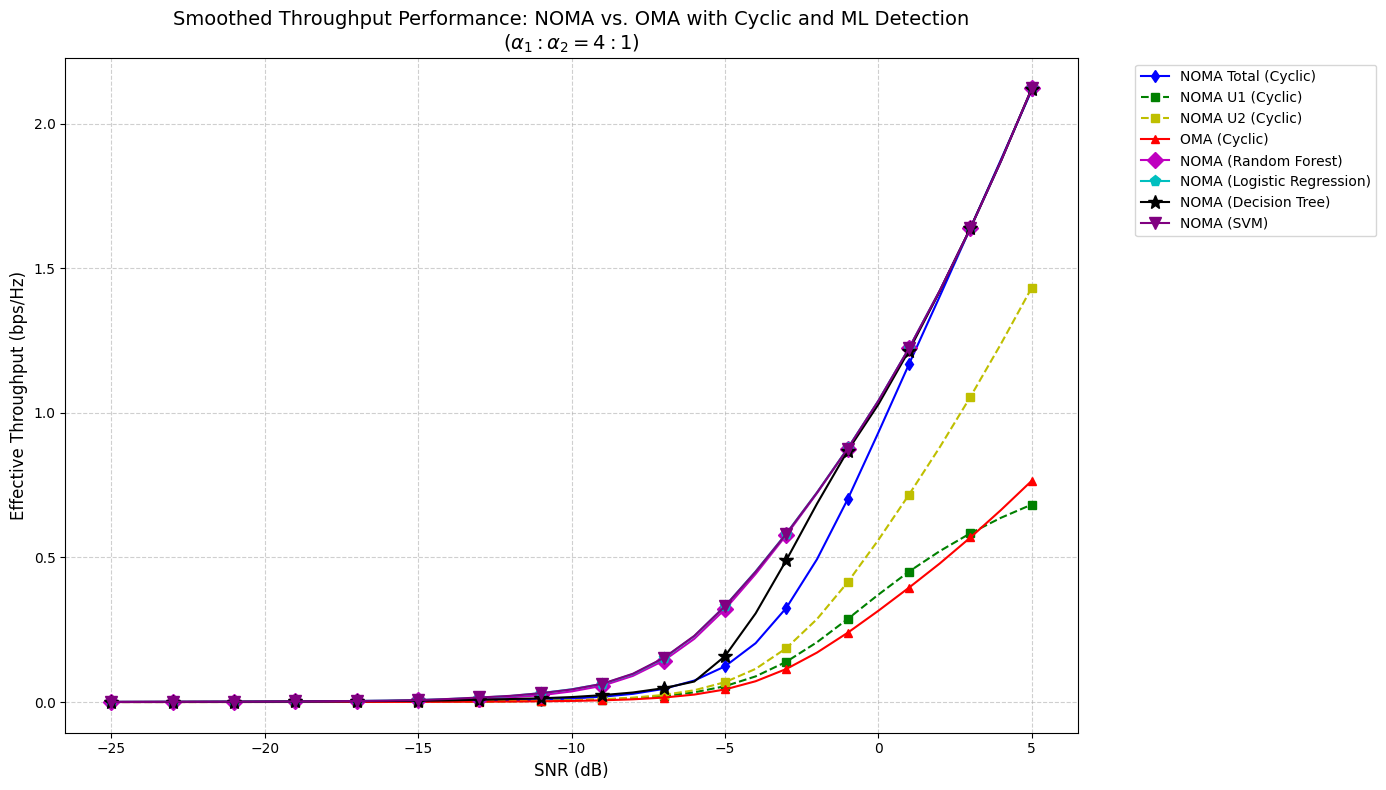

In [14]:
# ---------------------
# 6) Plot Results
# ---------------------
window_length = 7
polyorder = 2

def smooth(data):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder)

th_noma_u1_s = smooth(th_noma_u1)
th_noma_u2_s = smooth(th_noma_u2)
th_noma_total_s = smooth(th_noma_total)
th_oma_s = smooth(th_oma)
th_noma_rf_s = smooth(th_noma_rf)
th_noma_lr_s = smooth(th_noma_lr)
th_noma_dt_s = smooth(th_noma_dt)
th_noma_svm_s = smooth(th_noma_svm)

plt.figure(figsize=(14, 8))
plt.plot(SNR_dB, th_noma_total_s, 'b-d', label='NOMA Total (Cyclic)', markevery=2)
plt.plot(SNR_dB, th_noma_u1_s, 'g--s', label='NOMA U1 (Cyclic)', markevery=2)
plt.plot(SNR_dB, th_noma_u2_s, 'y--s', label='NOMA U2 (Cyclic)', markevery=2)
plt.plot(SNR_dB, th_oma_s, 'r-^', label='OMA (Cyclic)', markevery=2)
plt.plot(SNR_dB, th_noma_rf_s, 'm-D', label='NOMA (Random Forest)', markevery=2, markersize=8)
plt.plot(SNR_dB, th_noma_lr_s, 'c-p', label='NOMA (Logistic Regression)', markevery=2, markersize=8)
plt.plot(SNR_dB, th_noma_dt_s, 'k-*', label='NOMA (Decision Tree)', markevery=2, markersize=10)
plt.plot(SNR_dB, th_noma_svm_s, 'purple', marker='v', label='NOMA (SVM)', markevery=2, markersize=8)
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Effective Throughput (bps/Hz)', fontsize=12)
plt.title('Smoothed Throughput Performance: NOMA vs. OMA with Cyclic and ML Detection\n($\\alpha_1 : \\alpha_2 = 4:1$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('noma_oma_ml_throughput_comparison_smooth.png', dpi=300)
plt.show()


In [15]:
# ---------------------
# 7) Analysis at 0 dB
# ---------------------
idx_0dB = np.where(SNR_dB == 0)[0][0]
print("\nThroughput Analysis at SNR = 0 dB:")
print(f"NOMA U1 (Cyclic): {th_noma_u1[idx_0dB]:.4f} bps/Hz")
print(f"NOMA U2 (Cyclic): {th_noma_u2[idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic): {th_noma_total[idx_0dB]:.4f} bps/Hz")
print(f"OMA (Cyclic): {th_oma[idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Random Forest): {th_noma_rf[idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Logistic Regression): {th_noma_lr[idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Decision Tree): {th_noma_dt[idx_0dB]:.4f} bps/Hz")
print(f"NOMA (SVM): {th_noma_svm[idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic)/OMA Ratio: {th_noma_total[idx_0dB] / th_oma[idx_0dB]:.4f}")



Throughput Analysis at SNR = 0 dB:
NOMA U1 (Cyclic): 0.3736 bps/Hz
NOMA U2 (Cyclic): 0.5629 bps/Hz
NOMA Total (Cyclic): 0.9365 bps/Hz
OMA (Cyclic): 0.3172 bps/Hz
NOMA (Random Forest): 1.0411 bps/Hz
NOMA (Logistic Regression): 1.0416 bps/Hz
NOMA (Decision Tree): 1.0283 bps/Hz
NOMA (SVM): 1.0416 bps/Hz
NOMA Total (Cyclic)/OMA Ratio: 2.9522
